In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import set_random_seed
set_random_seed(1)
plt.rcParams["figure.figsize"] = (12,7)
sns.set_style("darkgrid")

In [3]:
df = pd.read_csv("data/space_embedding_data.csv", index_col=[0])
df.head()

,Grid,PlaceCount,Price 1,Price 2,Price 3,Accommodation,Bar,Cafe,Cultural,Education,...,Health_rating,Other_rating,Outdoors_rating,Restaurant_rating,Retail_rating,Service_rating,Wholesale_rating,PositiveReviews,NegativeReviews,ReviewLength
0,L0,8,0,1,0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.020000,0.0,3.942857,0.000000,0.000000,0.000000,0.696000,0.304000,0.536595
1,L1,10,0,1,0,0.0,0.0,1.0,0.0,0.0,...,5.0,0.000000,0.0,4.777778,0.000000,4.000000,0.000000,0.851852,0.148148,0.802238
2,L10,3,0,0,0,0.0,0.0,0.0,0.0,1.0,...,0.0,4.200000,0.0,0.000000,0.000000,0.000000,0.000000,0.857143,0.142857,0.999095
3,L100,74,2,9,6,12.0,6.0,6.0,0.0,1.0,...,3.6,4.024460,0.0,3.711172,4.500000,3.028846,0.000000,0.732975,0.267025,0.895548
4,L101,163,7,31,5,21.0,19.0,20.0,1.0,1.0,...,4.5,4.223132,0.0,3.748855,3.549446,4.311111,3.722222,0.801535,0.198465,0.843739


In [4]:
y = df[[i for i in df.columns if "_rating" not in i]].drop(["Grid"], axis=1)
X = pd.get_dummies(df.Grid).values

print("Targets shape:", y.shape)
print("Input shape:", X.shape)

Targets shape: (480, 21)
Input shape: (480, 480)


In [5]:
# Standard scaling of features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
y_tf = sc.fit_transform(y)

# Space Embeddings model

## Model architecture

Describe model architecture (make drawing in Lucidchart or draw.io)

## Continuous features

In [6]:
from keras.models import Model
from keras.layers import Dense, Embedding, Flatten
from keras import Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
# https://www.tensorflow.org/tutorials/keras/keras_tuner
def model_builder_continuous(hp):
    input_neurons = X.shape[0]

    # Model architecture
    inp = Input(shape=(input_neurons,))
    hp_embedding = hp.Int("units", min_value=5, max_value=15, step=1)
    emb = Embedding(input_dim=input_neurons, output_dim=hp_embedding, input_length=input_neurons)(inp)
    flat = Flatten()(emb)

    # Output layer
    dict_losses = {}
    output_acts = []
    for idx in range(len(y.columns)):
        output_act = Dense(1, activation="linear", use_bias=True, name="output_layer_cont" + str(idx))(flat)
        output_acts.append(output_act)
        dict_losses['output_layer_cont' + str(idx)] = 'mean_squared_error'

    # Model compiling
    model = Model(inputs=inp, outputs=output_acts)
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-4, 0.001, 0.01, 0.1])
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(loss=dict_losses, optimizer=opt)
    return model


In [7]:
from keras.callbacks import EarlyStopping
objective = kt.Objective("loss", direction="min")
tuner = kt.Hyperband(model_builder_continuous,
                    objective=objective,
                    max_epochs=10,
                    directory="hyperparameter_tuning",
                    project_name="continuous_trials",
                    overwrite=True
)

stop_early = EarlyStopping(monitor="loss", patience=5)

tuner.search(X, y_tf, callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters()[0]

Trial 30 Complete [00h 00m 10s]
loss: 11.953197479248047

Best loss So Far: 11.953197479248047
Total elapsed time: 00h 04m 16s
INFO:tensorflow:Oracle triggered exit


In [8]:
# Rebuild model with best hyperparameters
model = tuner.hypermodel.build(best_hps)

# train model for 50 epochs
history = model.fit(X, y_tf, epochs=50, verbose=0)
train_loss_per_epoch = history.history['loss']

In [9]:
# Find best epoch in terms of train loss
best_epoch = train_loss_per_epoch.index(min(train_loss_per_epoch)) + 1

# Retrain the model with optimal epochs from above
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X, y_tf, epochs=best_epoch, verbose=0)

# Save model
hypermodel.save("models/continuous_model")

INFO:tensorflow:Assets written to: models/continuous_model\assets


## Discrete/categorical features

In [30]:
# Defining a function for uniform discretizing of the features
# Can only handle features with less than 20% zero values. 
# Minimum number of bins are set to 3 and the maximum number of bins are 10

def uniform_Discretization(array):
    minspan = []
    
    # max number og bins is 10 (7+3)
    max_bins = 7
    #if input contains zeros, adjust max number of bins
    if np.any(array==0):
        max_bins = np.int32(np.floor(1/(len(np.where(array==0)[0])/len(array))))-2

    # find optimal number of bins with least variation in binsize
    # min number og bins = 3
    for i in range(max_bins-3):
        Value_count = pd.qcut(array,i+3).value_counts()
        minspan.append(max(Value_count)-min(Value_count))

    bins = np.argmin(minspan)+3
    intervals = np.unique(pd.qcut(array,bins))
    
    # print number of bins and bin intervals
    print(array.name,'- Bins: ', bins,'--',' '.join(str(x) for x in intervals))
    
    # uniform discretized bin 
    uniform_vals = pd.qcut(array,bins, labels=False)
    
    return uniform_vals


In [147]:
# Transforming the dataset to uniform discretized values, for features with less than 20% zeros
y_discrete = pd.DataFrame()
for i in range(len(y.columns)-1):
    columns = y.columns
    
    if len(np.where(y[columns[i+1]]==0)[0])/len(y[columns[i+1]])<0.2:
        y_discrete[columns[i+1]] = uniform_Discretization(y[columns[i+1]])
        y_discrete[columns[i+1]] = y_discrete[columns[i+1]].astype("category", copy=False)
    else:
        0
    #data[columns[i+]] = uniform_Discretization(df[columns[i+1]])

Bar - Bins:  3 -- (-0.001, 2.0] (2.0, 6.0] (6.0, 133.0]
Other - Bins:  3 -- (-0.001, 2.0] (2.0, 6.0] (6.0, 91.0]
Restaurant - Bins:  3 -- (-0.001, 3.0] (3.0, 13.0] (13.0, 263.0]
ReviewCount - Bins:  5 -- (3.999, 40.8] (40.8, 99.2] (99.2, 225.4] (225.4, 638.2] (638.2, 8699.0]
Rating - Bins:  3 -- (1.5550000000000002, 3.941] (3.941, 4.13] (4.13, 5.0]
PositiveReviews - Bins:  4 -- (0.311, 0.792] (0.792, 0.833] (0.833, 0.864] (0.864, 1.0]
NegativeReviews - Bins:  4 -- (-0.001, 0.136] (0.136, 0.167] (0.167, 0.208] (0.208, 0.688]
ReviewLength - Bins:  3 -- (0.0665, 0.899] (0.899, 1.099] (1.099, 2.218]


In [148]:
y_discrete = pd.get_dummies(y_discrete)
y_discrete = y_discrete.astype(float)
y_discrete.head()

,Bar_0,Bar_1,Bar_2,Other_0,Other_1,Other_2,Restaurant_0,Restaurant_1,Restaurant_2,ReviewCount_0,...,PositiveReviews_1,PositiveReviews_2,PositiveReviews_3,NegativeReviews_0,NegativeReviews_1,NegativeReviews_2,NegativeReviews_3,ReviewLength_0,ReviewLength_1,ReviewLength_2
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [163]:
input_neurons = X.shape[0]

# Model architecture
inp = Input(shape=(input_neurons,))
#hp_embedding = hp.Int("units", min_value=3, max_value=6, step=1)
emb = Embedding(input_dim=input_neurons, output_dim=5, input_length=input_neurons)(inp)
flat = Flatten()(emb)

# Output layer
dict_losses = {}
output_acts = []
for idx in range(len(y_discrete.columns)):
    n_output = y_discrete.iloc[:, idx].nunique()
    output_act = Dense(1, activation="sigmoid", use_bias=True, name="output_layer_cat" + str(idx))(flat)
    output_acts.append(output_act)
    dict_losses['output_layer_cat' + str(idx)] = 'categorical_crossentropy'

# Model compiling
model = Model(inputs=inp, outputs=output_acts)

In [164]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 480)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 480, 5)       2400        ['input_2[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 2400)         0           ['embedding_1[0][0]']            
                                                                                                  
 output_layer_cat0 (Dense)      (None, 1)            2401        ['flatten_1[0][0]']              
                                                                                            

In [154]:
def model_builder_discrete(hp):
    input_neurons = X.shape[0]

    # Model architecture
    inp = Input(shape=(input_neurons,))
    hp_embedding = hp.Int("units", min_value=3, max_value=6, step=1)
    emb = Embedding(input_dim=input_neurons, output_dim=hp_embedding, input_length=input_neurons)(inp)
    flat = Flatten()(emb)

    # Output layer
    dict_losses = {}
    output_acts = []
    for idx in range(len(y_discrete.columns)):
        n_output = y_discrete.iloc[:, idx].nunique()
        output_act = Dense(1, activation="softmax", use_bias=True, name="output_layer_cat" + str(idx))(flat)
        output_acts.append(output_act)
        dict_losses['output_layer_cat' + str(idx)] = 'binary_crossentropy'

    # Model compiling
    model = Model(inputs=inp, outputs=output_acts)
    hp_learning_rate = hp.Choice('learning_rate', values=[3e-4, 0.001, 0.01, 0.1])
    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(loss=dict_losses, optimizer=opt)
    return model

In [165]:
objective = kt.Objective("loss", direction="min")
tuner = kt.Hyperband(model_builder_discrete,
                    objective=objective,
                    max_epochs=10,
                    directory="hyperparameter_tuning",
                    project_name="discrete_trials",
                    overwrite=True
)

stop_early = EarlyStopping(monitor="loss", patience=5)

tuner.search(X, y_discrete.values, callbacks=[stop_early])
best_hps = tuner.get_best_hyperparameters()[0]


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
5                 |?                 |units
0.1               |?                 |learning_rate
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
2                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/2


ValueError: in user code:

    File "c:\Users\Bruger\Documents\GoogleLocalReviews\abaenv\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Bruger\Documents\GoogleLocalReviews\abaenv\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Bruger\Documents\GoogleLocalReviews\abaenv\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Bruger\Documents\GoogleLocalReviews\abaenv\lib\site-packages\keras\engine\training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Bruger\Documents\GoogleLocalReviews\abaenv\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Bruger\Documents\GoogleLocalReviews\abaenv\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Bruger\Documents\GoogleLocalReviews\abaenv\lib\site-packages\keras\losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Bruger\Documents\GoogleLocalReviews\abaenv\lib\site-packages\keras\losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Bruger\Documents\GoogleLocalReviews\abaenv\lib\site-packages\keras\losses.py", line 1932, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\Bruger\Documents\GoogleLocalReviews\abaenv\lib\site-packages\keras\backend.py", line 5247, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((32, 1) vs (32, 28)).


In [ ]:
# Rebuild model with best hyperparameters
model = tuner.hypermodel.build(best_hps)

# train model for 50 epochs
history = model.fit(X, y_discrete, epochs=50, verbose=0)
train_loss_per_epoch = history.history['loss']

In [ ]:
# Find best epoch in terms of train loss
best_epoch = train_loss_per_epoch.index(min(train_loss_per_epoch)) + 1

# Retrain the model with optimal epochs from above
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X, y_discrete, epochs=best_epoch, verbose=0)

# Save model
hypermodel.save("models/discrete_model")

## Model comparison (Continuous vs Discrete/Categorical)

Compare models and find the "best" model. Plot loss curves and TSNE for the best model

In [ ]:
for idx, (key, value) in enumerate(history.history.items()):
    if key != "loss":
        plt.plot(history.epoch, value, label=y.columns[idx-1])
plt.ylabel("Loss")
plt.xlabel("Epochs");
plt.legend();

In [ ]:
from sklearn.metrics import mean_squared_error
continuous_model = []
y_pred = model.predict(X)
y_pred = np.array(y_pred).T.squeeze()
for i in range(y_pred.shape[1]):
    mse_feature = mean_squared_error(y_tf[:, i], y_pred[:, i])
    print(y.columns[i], "MSE:", mse_feature)
    continuous_model.append(mse_feature)

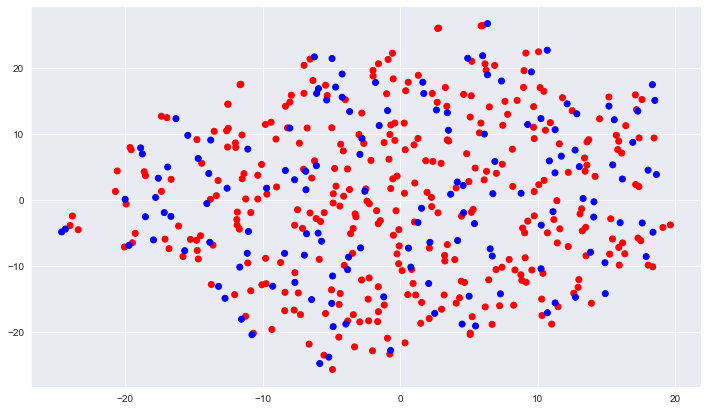

In [15]:
from sklearn.manifold import TSNE
embeddings = model.layers[1].get_weights()[0]
colors = (df.Grid.str.startswith("L")*1).values
colors = ["red" if i==1 else "blue" for i in colors]
X_emb = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(embeddings)

plt.figure(figsize=(12,7))
plt.scatter(X_emb[:, 0], X_emb[:, 1], color=colors);
# make legend